# Verifiers Evaluation Analysis

This notebook analyzes the evaluation results from the SWE-Grep OSS environment, focusing on the reward metrics defined in the rubric.


In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

mkdir -p failed for path /home/ubuntu/.config/matplotlib: [Errno 13] Permission denied: '/home/ubuntu/.config/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-z965c7ey because there was an issue with the default path (/home/ubuntu/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Load Data

Load the evaluation results from the JSONL file.


In [2]:
# Define multiple result paths to compare
results_paths = [
    {
        "path": Path("../outputs/evals/swe-grep-oss-env--Qwen--Qwen3-8B/78b0c169/results.jsonl"),
        "label": "Run 1 (78b0c169)",
        "color": "#1f77b4"
    },
    {
        "path": Path("../outputs/evals/swe-grep-oss-env--Qwen--Qwen3-8B/d297f7fa/results.jsonl"),
        "label": "Run 2 (d297f7fa)",
        "color": "#ff7f0e"
    },
]

all_dfs = []
for result_config in results_paths:
    data = []
    with open(result_config["path"], "r") as f:
        for line in f:
            data.append(json.loads(line))
    
    df_temp = pd.DataFrame(data)
    df_temp["run_label"] = result_config["label"]
    df_temp["run_color"] = result_config["color"]
    all_dfs.append(df_temp)
    print(f"Loaded {len(data)} evaluation results from {result_config['label']}")

# Combine all dataframes
df = pd.concat(all_dfs, ignore_index=True)
print(f"\nTotal: {len(df)} evaluation results across {len(results_paths)} run(s)")
df.head()

Loaded 300 evaluation results from Run 1 (78b0c169)
Loaded 300 evaluation results from Run 2 (d297f7fa)

Total: 600 evaluation results across 2 run(s)


,example_id,prompt,completion,task,reward,generation_ms,scoring_ms,total_ms,info,answer,result_tool_check,result_tool_f1,result_tool_precision,result_tool_recall,tool_call_count,max_tokens_check,run_label,run_color
0,0,[{'content': ' You are a helpful assistant tha...,"[{'content': ' ', 'role': 'assistant', 'tool_...",default,7.0,325858.666420,7.426739,325866.093159,"{'instance_id': 'astropy__astropy-12907', 'max...",diff --git a/astropy/modeling/separable.py b/a...,1.0,0.0,0.0,0.0,5.0,1.0,Run 1 (78b0c169),#1f77b4
1,1,[{'content': ' You are a helpful assistant tha...,"[{'content': ' ', 'role': 'assistant', 'tool_...",default,2.0,0.000000,7.534504,7.534504,"{'instance_id': 'astropy__astropy-14182', 'max...",diff --git a/astropy/io/ascii/rst.py b/astropy...,0.0,0.0,0.0,0.0,2.0,0.0,Run 1 (78b0c169),#1f77b4
2,2,[{'content': ' You are a helpful assistant tha...,"[{'content': ' ', 'role': 'assistant', 'tool_...",default,7.0,455875.408649,7.360458,455882.769108,"{'instance_id': 'astropy__astropy-14365', 'max...",diff --git a/astropy/io/ascii/qdp.py b/astropy...,1.0,0.0,0.0,0.0,5.0,1.0,Run 1 (78b0c169),#1f77b4
3,3,[{'content': ' You are a helpful assistant tha...,"[{'content': ' <tool_call> {""name"": ""bash"", ""...",default,1.0,64561.590195,15.353203,64576.943398,"{'instance_id': 'astropy__astropy-14995', 'max...",diff --git a/astropy/nddata/mixins/ndarithmeti...,0.0,0.0,0.0,0.0,0.0,1.0,Run 1 (78b0c169),#1f77b4
4,4,[{'content': ' You are a helpful assistant tha...,"[{'content': ' ', 'role': 'assistant', 'tool_...",default,5.0,160655.382633,7.596493,160662.979126,"{'instance_id': 'astropy__astropy-6938', 'max_...",diff --git a/astropy/io/fits/fitsrec.py b/astr...,1.0,0.0,0.0,0.0,3.0,1.0,Run 1 (78b0c169),#1f77b4


## Reward Metrics Overview

The following reward metrics are defined in the rubric:

1. **result_tool_check**: Whether the result tool was called
2. **result_tool_f1**: F1 score of predicted file paths
3. **result_tool_precision**: Precision of predicted file paths
4. **result_tool_recall**: Recall of predicted file paths
5. **tool_call_count**: Number of tool calls made (normalized)
6. **max_tokens_check**: Whether token limit was exceeded


In [3]:
# Extract reward columns
reward_columns = [
    "result_tool_check",
    "result_tool_f1",
    "result_tool_precision",
    "result_tool_recall",
    "tool_call_count",
    "max_tokens_check",
    "reward",
]

# Display basic statistics for each run
for run_label in df["run_label"].unique():
    print(f"\n{'='*60}")
    print(f"Statistics for: {run_label}")
    print('='*60)
    run_df = df[df["run_label"] == run_label]
    print(run_df[reward_columns].describe())
    print()


Statistics for: Run 1 (78b0c169)
       result_tool_check  result_tool_f1  result_tool_precision  \
count         300.000000      300.000000             300.000000   
mean            0.746667        0.199512               0.177336   
std             0.435647        0.356754               0.340640   
min             0.000000        0.000000               0.000000   
25%             0.000000        0.000000               0.000000   
50%             1.000000        0.000000               0.000000   
75%             1.000000        0.333333               0.200000   
max             1.000000        1.000000               1.000000   

       result_tool_recall  tool_call_count  max_tokens_check      reward  
count          300.000000       300.000000        300.000000  300.000000  
mean             0.276667         4.286667          0.936667    6.623515  
std              0.448098         1.489480          0.243968    2.362828  
min              0.000000         0.000000          0.000000  

## Distribution of Individual Rewards


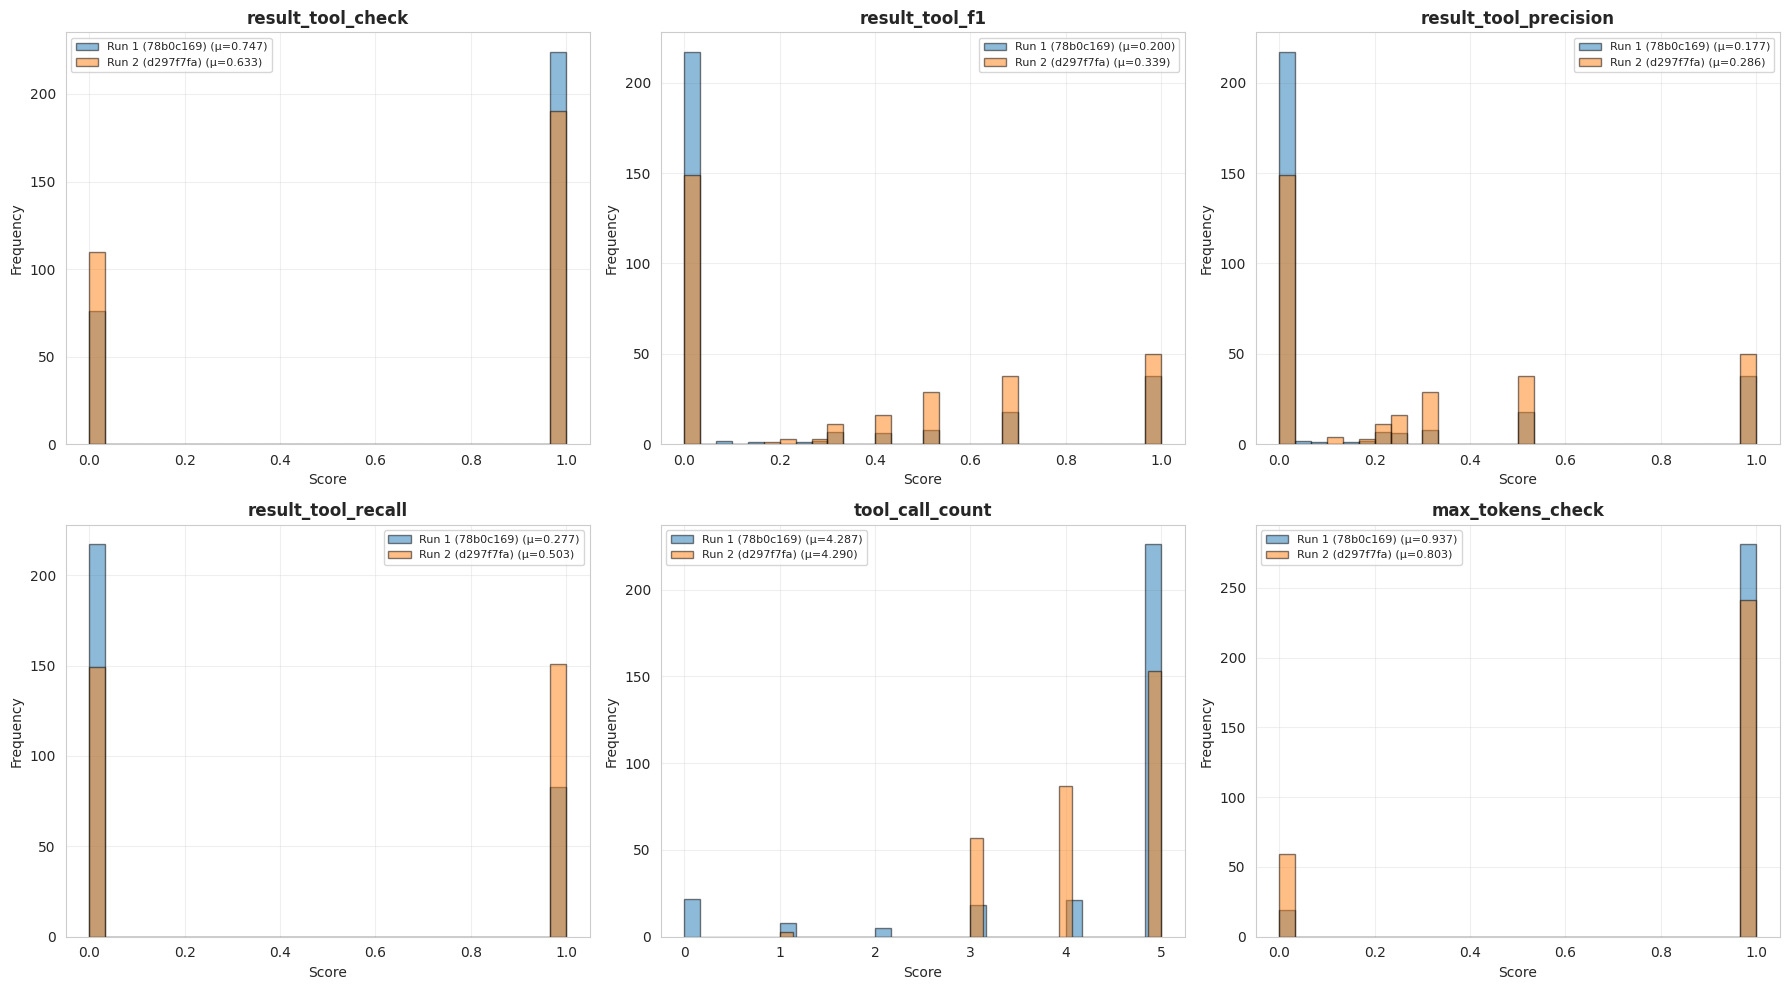

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

reward_metrics = [
    "result_tool_check",
    "result_tool_f1",
    "result_tool_precision",
    "result_tool_recall",
    "tool_call_count",
    "max_tokens_check",
]

for idx, metric in enumerate(reward_metrics):
    ax = axes[idx]
    
    # Plot histogram for each run
    for run_label in df["run_label"].unique():
        run_df = df[df["run_label"] == run_label]
        data_to_plot = run_df[metric].dropna()
        run_color = run_df["run_color"].iloc[0]
        
        # Create histogram with transparency for overlapping
        ax.hist(
            data_to_plot, 
            bins=30, 
            edgecolor="black", 
            alpha=0.5,
            label=f"{run_label} (μ={data_to_plot.mean():.3f})",
            color=run_color
        )
    
    ax.set_title(f"{metric}", fontsize=12, fontweight="bold")
    ax.set_xlabel("Score")
    ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='best')

plt.tight_layout()
plt.show()

## Overall Performance Metrics

Aggregate metrics across all evaluation instances:


OVERALL PERFORMANCE METRICS - Run 1 (78b0c169)
Accuracy (Result Tool Called) : 0.7467 (74.67%)
F1 Score                      : 0.1995 (19.95%)
Precision                     : 0.1773 (17.73%)
Recall                        : 0.2767 (27.67%)

OVERALL PERFORMANCE METRICS - Run 2 (d297f7fa)
Accuracy (Result Tool Called) : 0.6333 (63.33%)
F1 Score                      : 0.3387 (33.87%)
Precision                     : 0.2861 (28.61%)
Recall                        : 0.5033 (50.33%)



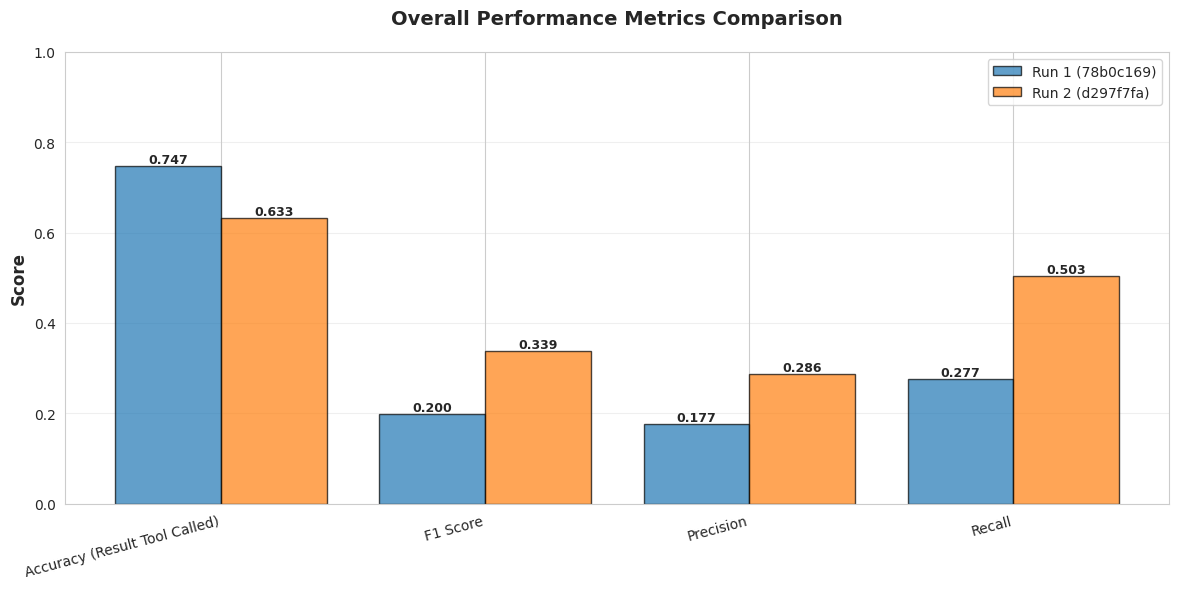

In [5]:
# Calculate overall metrics for each run
metric_names = [
    "Accuracy (Result Tool Called)",
    "F1 Score",
    "Precision",
    "Recall",
]

metric_columns = [
    "result_tool_check",
    "result_tool_f1",
    "result_tool_precision",
    "result_tool_recall",
]

# Display as a formatted table
for run_label in df["run_label"].unique():
    run_df = df[df["run_label"] == run_label]
    overall_metrics = {
        name: run_df[col].mean()
        for name, col in zip(metric_names, metric_columns)
    }
    
    print("=" * 60)
    print(f"OVERALL PERFORMANCE METRICS - {run_label}")
    print("=" * 60)
    for metric_name, value in overall_metrics.items():
        print(f"{metric_name:30s}: {value:.4f} ({value*100:.2f}%)")
    print("=" * 60)
    print()

# Create a grouped bar chart comparing all runs
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metric_names))
width = 0.8 / len(df["run_label"].unique())  # Dynamic width based on number of runs

for idx, run_label in enumerate(df["run_label"].unique()):
    run_df = df[df["run_label"] == run_label]
    run_color = run_df["run_color"].iloc[0]
    
    metrics_values = [
        run_df[col].mean() for col in metric_columns
    ]
    
    offset = (idx - len(df["run_label"].unique())/2 + 0.5) * width
    bars = ax.bar(
        x + offset,
        metrics_values,
        width,
        label=run_label,
        color=run_color,
        alpha=0.7,
        edgecolor="black",
    )
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
        )

ax.set_ylabel("Score", fontsize=12, fontweight="bold")
ax.set_title(
    "Overall Performance Metrics Comparison",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend(fontsize=10, loc='upper right')
ax.set_ylim(0, 1.0)  # Fixed scale for comparison
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

## Tool Call Analysis

Distribution of tool calls and errors per instance:


TOOL CALL STATISTICS - Run 1 (78b0c169)
Total tool calls:      mean=5.88, median=6, max=28
Error tool calls:      mean=1.45, median=1, max=9
Error percentage:      mean=21.16%

TOOL CALL STATISTICS - Run 2 (d297f7fa)
Total tool calls:      mean=6.14, median=5, max=21
Error tool calls:      mean=0.97, median=0, max=16
Error percentage:      mean=10.78%



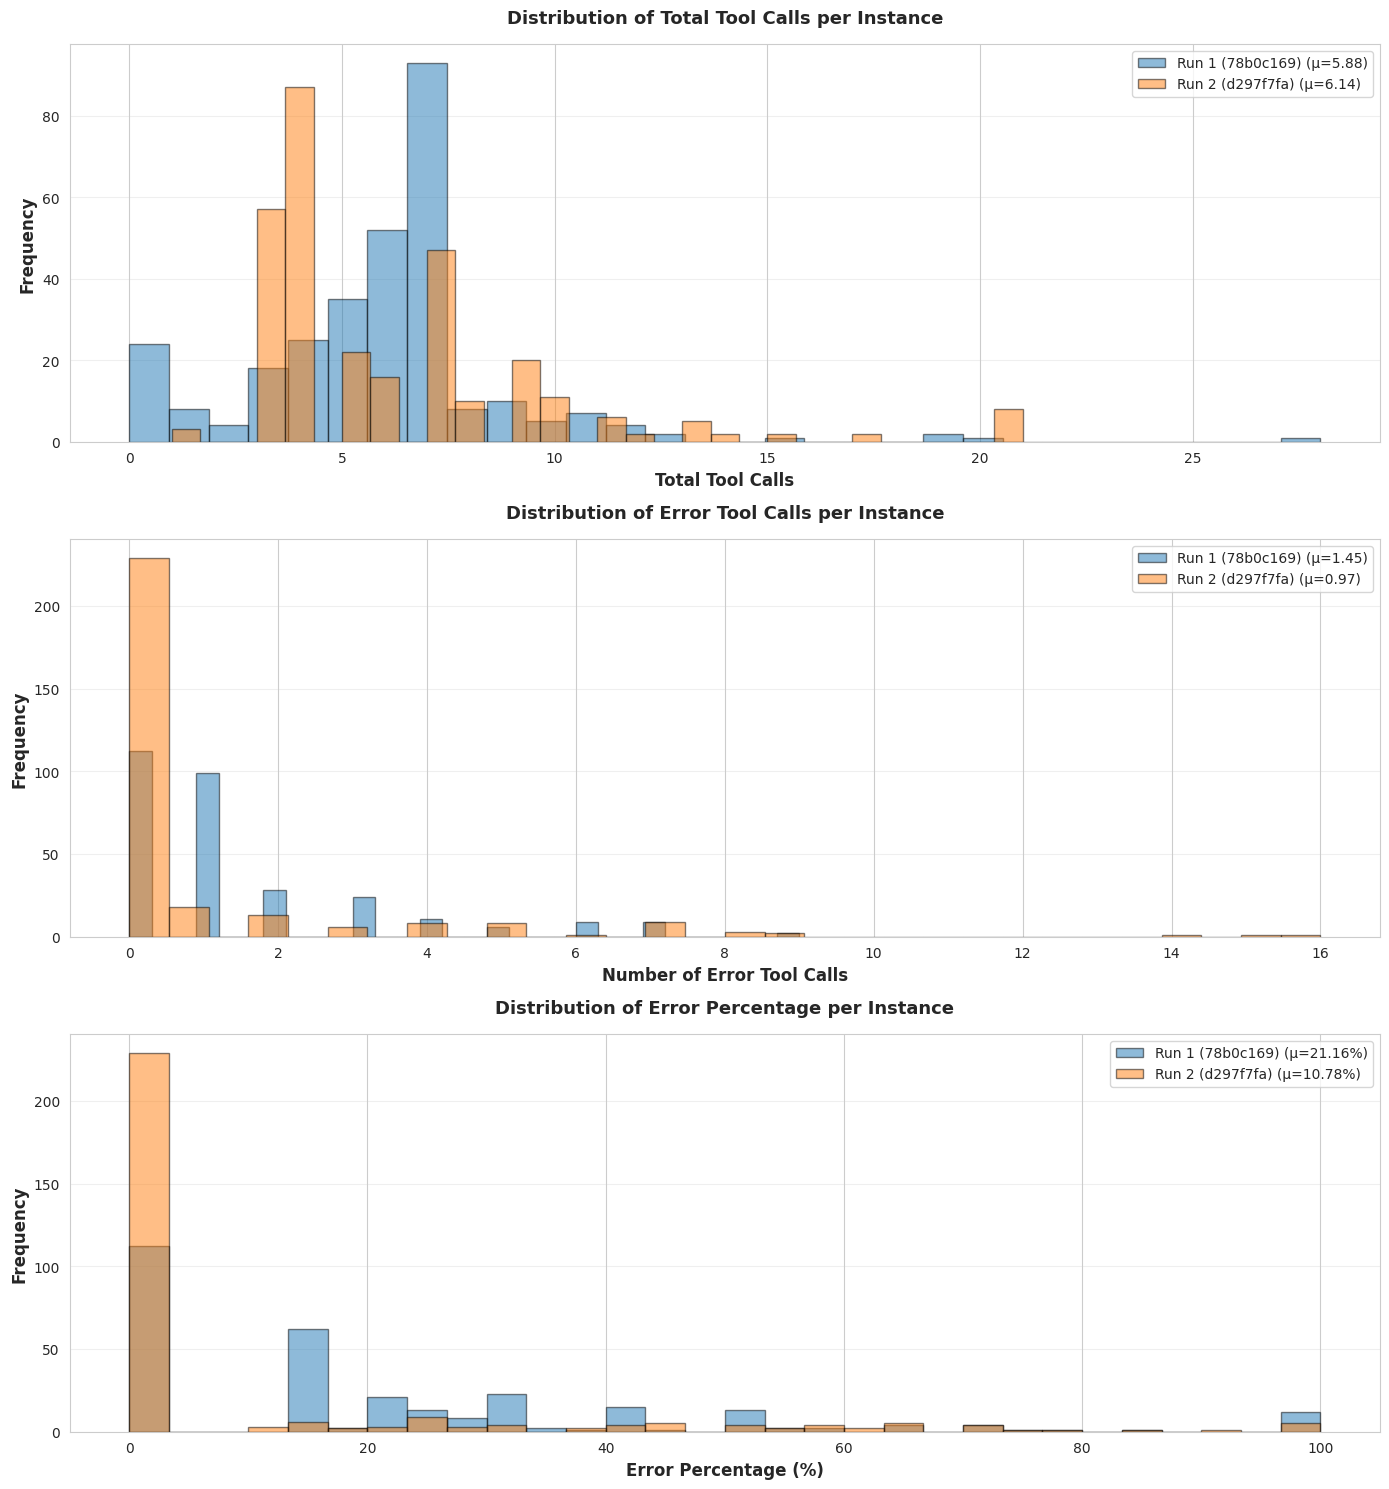

In [6]:
# Count tool messages for each instance
total_tool_counts = []
error_tool_counts = []
error_percentages = []

for idx, row in df.iterrows():
    completion = row["completion"]
    total_tools = 0
    error_tools = 0

    for message in completion:
        if message.get("role") == "tool":
            total_tools += 1
            content = message.get("content", "")
            if content.startswith("Error"):
                error_tools += 1

    total_tool_counts.append(total_tools)
    error_tool_counts.append(error_tools)
    error_percentage = (
        (error_tools / total_tools * 100) if total_tools > 0 else 0
    )
    error_percentages.append(error_percentage)

# Add to dataframe
df["total_tool_count"] = total_tool_counts
df["error_tool_count"] = error_tool_counts
df["error_tool_percentage"] = error_percentages

# Display summary statistics for each run
for run_label in df["run_label"].unique():
    run_df = df[df["run_label"] == run_label]
    run_total_counts = run_df["total_tool_count"].tolist()
    run_error_counts = run_df["error_tool_count"].tolist()
    run_error_pcts = run_df["error_tool_percentage"].tolist()
    
    print("=" * 60)
    print(f"TOOL CALL STATISTICS - {run_label}")
    print("=" * 60)
    print(
        f"Total tool calls:      mean={sum(run_total_counts)/len(run_total_counts):.2f}, "
        f"median={sorted(run_total_counts)[len(run_total_counts)//2]}, "
        f"max={max(run_total_counts)}"
    )
    print(
        f"Error tool calls:      mean={sum(run_error_counts)/len(run_error_counts):.2f}, "
        f"median={sorted(run_error_counts)[len(run_error_counts)//2]}, "
        f"max={max(run_error_counts)}"
    )
    print(
        f"Error percentage:      mean={sum(run_error_pcts)/len(run_error_pcts):.2f}%"
    )
    print("=" * 60)
    print()

# Visualize distributions with comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 15))

# 1. Total tool calls per instance
ax1 = axes[0]
for run_label in df["run_label"].unique():
    run_df = df[df["run_label"] == run_label]
    run_color = run_df["run_color"].iloc[0]
    run_total_counts = run_df["total_tool_count"].tolist()
    
    ax1.hist(
        run_total_counts,
        bins=30,
        edgecolor="black",
        alpha=0.5,
        label=f"{run_label} (μ={sum(run_total_counts)/len(run_total_counts):.2f})",
        color=run_color
    )

ax1.set_xlabel("Total Tool Calls", fontsize=12, fontweight="bold")
ax1.set_ylabel("Frequency", fontsize=12, fontweight="bold")
ax1.set_title(
    "Distribution of Total Tool Calls per Instance",
    fontsize=13,
    fontweight="bold",
    pad=15,
)
ax1.grid(True, alpha=0.3, axis="y")
ax1.legend(fontsize=10, loc='best')

# 2. Error tool calls per instance
ax2 = axes[1]
for run_label in df["run_label"].unique():
    run_df = df[df["run_label"] == run_label]
    run_color = run_df["run_color"].iloc[0]
    run_error_counts = run_df["error_tool_count"].tolist()
    
    ax2.hist(
        run_error_counts,
        bins=30,
        edgecolor="black",
        alpha=0.5,
        label=f"{run_label} (μ={sum(run_error_counts)/len(run_error_counts):.2f})",
        color=run_color
    )

ax2.set_xlabel("Number of Error Tool Calls", fontsize=12, fontweight="bold")
ax2.set_ylabel("Frequency", fontsize=12, fontweight="bold")
ax2.set_title(
    "Distribution of Error Tool Calls per Instance",
    fontsize=13,
    fontweight="bold",
    pad=15,
)
ax2.grid(True, alpha=0.3, axis="y")
ax2.legend(fontsize=10, loc='best')

# 3. Error percentage per instance
ax3 = axes[2]
for run_label in df["run_label"].unique():
    run_df = df[df["run_label"] == run_label]
    run_color = run_df["run_color"].iloc[0]
    run_error_pcts = run_df["error_tool_percentage"].tolist()
    
    ax3.hist(
        run_error_pcts,
        bins=30,
        edgecolor="black",
        alpha=0.5,
        label=f"{run_label} (μ={sum(run_error_pcts)/len(run_error_pcts):.2f}%)",
        color=run_color
    )

ax3.set_xlabel("Error Percentage (%)", fontsize=12, fontweight="bold")
ax3.set_ylabel("Frequency", fontsize=12, fontweight="bold")
ax3.set_title(
    "Distribution of Error Percentage per Instance",
    fontsize=13,
    fontweight="bold",
    pad=15,
)
ax3.grid(True, alpha=0.3, axis="y")
ax3.legend(fontsize=10, loc='best')

plt.tight_layout()
plt.show()